In [13]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

In [93]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 1000000
N_test = 5000
checkpoint_interval = 5000
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

#learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
learn_alg = RTRL(rnn, L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=0.0001, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

Progress: 10.0% complete 
Time Elapsed: 66.1s 
Test loss: 0.5117770560729062 

Progress: 20.0% complete 
Time Elapsed: 131.7s 
Test loss: 0.5154397503857967 

Progress: 30.0% complete 
Time Elapsed: 197.3s 
Test loss: 0.6233192305974903 

Progress: 40.0% complete 
Time Elapsed: 263.4s 
Test loss: 0.3627198751284152 

Progress: 50.0% complete 
Time Elapsed: 330.2s 
Test loss: 0.3968123123801191 

Progress: 60.0% complete 
Time Elapsed: 395.9s 
Test loss: 0.01366533669961406 

Progress: 70.0% complete 
Time Elapsed: 461.5s 
Test loss: 0.0046442857531630065 

Progress: 80.0% complete 
Time Elapsed: 526.9s 
Test loss: 0.003305180733393776 

Progress: 90.0% complete 
Time Elapsed: 592.5s 
Test loss: 0.002623067055616574 



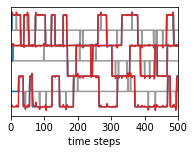

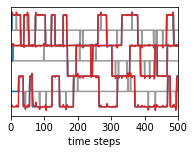

In [94]:
plot_output_from_checkpoint(sim.checkpoints[sorted(sim.checkpoints.keys())[-1]], data)

In [95]:
file_name = 'scratch'
with open(os.path.join('saved_runs/', file_name), 'wb') as f:
    saved_run = {'sim': sim, 'task': task}
    pickle.dump(saved_run, f)

In [ ]:
!ls /scratch/oem214/vanilla-rtrl/wrappers/analyze_main.py /scratch/oem214/learning-dynamics/cluster_main_scripts/

In [96]:
!du -sh saved_runs/scratch

112M	saved_runs/scratch


In [97]:
topological_analysis('scratch')

sending incremental file list

sent 10,870 bytes  received 45 bytes  21,830.00 bytes/sec
total size is 1,243,385  speedup is 113.92
sending incremental file list

sent 10,870 bytes  received 45 bytes  21,830.00 bytes/sec
total size is 1,243,385  speedup is 113.92


In [100]:
###Get job status
get_ipython().system('squeue -u oem214')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7869826        cs  jupyter   oem214  R    2:52:07      1 cs028


In [73]:
def unpack_compare_result(saved_run_name, checkpoint_stats={}):
    """Unpack the results of a full analysis -> compare run. Returns
    a dict of 'signals', i.e. numpy arrays with shape (n_checkpoints).
    
    Args:
        saved_run_name (str): Original file name of analyzed simulation
        checkpoint_stats (dict): Dictionary whose entries are
            functions that take in a checkpoint and return some float."""
    
    analysis_job_name = 'analyze_{}'.format(saved_run_name)
    compare_job_name = 'compare_{}'.format(saved_run_name)
    
    results_dir = '/scratch/oem214/learning-dynamics/results/'
    
    analysis_result_path = os.path.join(results_dir, analysis_job_name)
    compare_result_path = os.path.join(results_dir, compare_job_name)
    
    ### --- Unpack neighbor comparison results --- ###
    
    with open(comp_data_path, 'rb') as f:
        result = pickle.load(f)

    signals = {}
        
    for key in result.keys():

        if 'distance' in key:

            x = np.diag(result[key][:-1,1:])
            signals[key] = x.copy()
            
    ### --- Unpack individual checkpoint results --- ###
    
    indices, checkpoints = unpack_analysis_results(analysis_result_path)
            
    for key in checkpoint_stats.keys():
        
        stat_ = []
        
        for i_index, index in enumerate(indices):
            
            checkpoint = checkpoints['checkpoint_{}'.format(index)]
            stat_.append(checkpoint_stats[key](checkpoint))
        
        signals[key] = np.array(stat_)
            
    return signals

def get_checkpoint_loss(checkpoint):
    
    return checkpoint['test_loss']

In [101]:
signals = unpack_compare_result('scratch', checkpoint_stats={'test_loss': get_checkpoint_loss})

In [102]:
signals.keys()

dict_keys(['aligned_graph_distances', 'node_diff_distances', 'rec_weight_distances', 'test_loss'])

In [76]:
def plot_signals(signals, key_restriction=None, title=None):
    
    keys = signals.keys()
    if key_restriction is not None:
        keys = key_restriction
        
    fig = plt.figure(figsize=(10, 2 * len(keys)))
    leg = []
    for i_key, key in enumerate(keys):
        
        x = signals[key].copy()

        x_max = np.amax(x)
        x_min = np.amin(x)

        x = (x - x_min) / (x_max - x_min)

        plt.plot(x - 1.2 * i_key, color='C{}'.format(i_key))
        leg.append(key)
    
    plt.legend(leg)
    plt.yticks([])
    if title is not None:
        plt.title(title)
    
    return fig

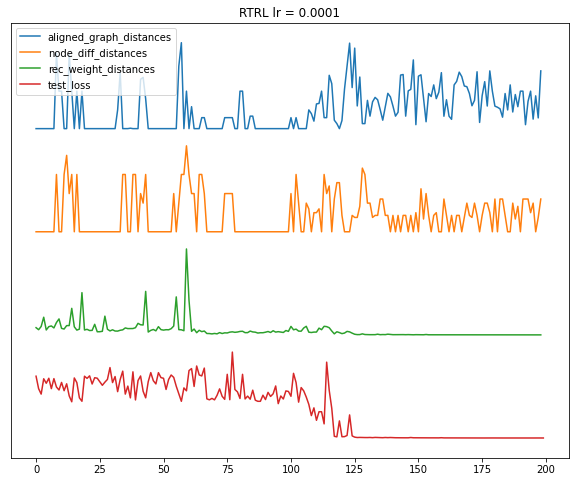

In [104]:
fig = plot_signals(signals, title='RTRL lr = 0.0001')
figs_path = 'figs/compare_algorithms/'
#fig.savefig(os.path.join(figs_path, 'RTRL_0001lr.pdf'), format='pdf')

Text(0.5, 1.0, 'RTRL')

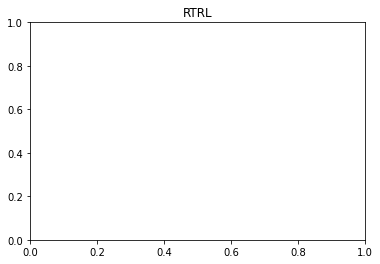

100


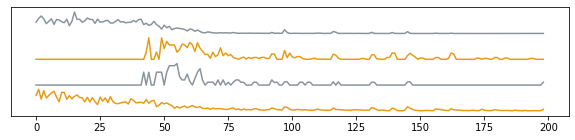

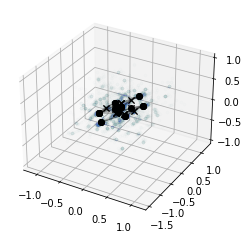

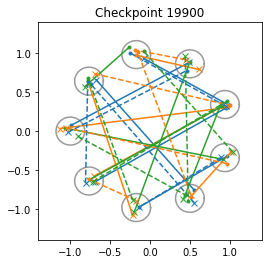

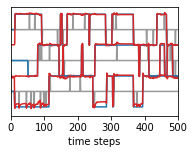

In [11]:
analysis_job_name = 'analyze_scratch'
compare_job_name = 'compare_scratch'
local_results = '/scratch/oem214/learning-dynamics/results/'
figs_path = '/Users/omarschall/career-stuff/thesis_committee/meeting_april-2021'
comp_data_path = os.path.join(local_results, compare_job_name, 'result_0')
data_path = os.path.join(local_results, analysis_job_name)
indices, checkpoints = unpack_analysis_results(data_path)
node_distances = []
losses = []
#grad_norms = []
rec_params = []
CCA_distances = []
largest_evals = []
weight_stds = []
CCA_data = task.gen_data(10, 1000)
for i_index in range(1, len(indices)):
    ref_checkpoint = checkpoints['checkpoint_{}'.format(indices[i_index - 1])]
    checkpoint = checkpoints['checkpoint_{}'.format(indices[i_index])]
    if i_index % 100 == 0:
        print(i_index)
    try:
        align_checkpoints(checkpoint, ref_checkpoint, n_inputs=4)
        align_checkpoints(checkpoint, ref_checkpoint, n_inputs=4)
    except ValueError:
        continue
    d = norm(np.array(checkpoint['corr_node_distances']))
    node_distances.append(d)
    losses.append(checkpoint['test_loss'])
    rnn = checkpoint['rnn']
    params = np.concatenate([rnn.W_rec.flatten(), rnn.W_in.flatten(), rnn.b_rec])
    rec_params.append(params)
    eigs, vecs = np.linalg.eig(checkpoint['rnn'].W_rec)
    largest_evals.append(np.abs(eigs[0]))
    weight_stds.append(rnn.W_rec.std())
    #CCA_distances.append(SVCCA_distance(checkpoint, ref_checkpoint, CCA_data))
    #grad_norms.append(norm(checkpoint['learn_alg'].rec_grads))
losses = np.array(losses)
rec_params = np.array(rec_params)
largest_evals = np.array(largest_evals)
norms = np.square(rec_params[1:] - rec_params[:-1]).sum(1)
node_distances = np.array(node_distances)
weight_stds = np.array(weight_stds)

#collect all signals
signals = {'losses': losses, 'node_distances': node_distances,
           'norms': norms, 'largest_evals': largest_evals,
           'weight_stds': weight_stds}
signals = {'losses': losses}
try:
    with open(comp_data_path, 'rb') as f:
        result = pickle.load(f)

    for i_key, key in enumerate(result.keys()):

        #if 'distances' in key or 'participation' in key:
        if 'distance' in key:

            x = np.diag(result[key][:-1,1:])
            signals[key] = x.copy()

except FileNotFoundError:
    print('file not found')
    pass

#Plot all signals

fig1 = plt.figure(figsize=(10,2))
leg = []
colors = ['#89949B', '#E89C15']
for i_key, key in enumerate(signals):

    x = signals[key].copy()

    x_max = np.amax(x)
    x_min = np.amin(x)

    # if 'PC' in key:
    #     x_max = 1
    #     x_min = 0

    x = (x - x_min) / (x_max - x_min)

    plt.plot(x - 1.2 * i_key, color=colors[i_key % 2])
    if key == 'largest_evals':
        unit_circle = (1 - x_min) / (x_max - x_min)
        plt.axhline(y=unit_circle - 1.2 * i_key, color=('0.6'), linestyle='--', label='_nolegend_')
    leg.append(key)

#plt.legend(leg)
#plt.xticks([0, 100, 200, 300, 400], ['0', '500k', '1M', '1.5M', '2M'])
plt.yticks([])



data = task.gen_data(100, 10000)
# sparse_inputs_task = Flip_Flop_Task(task.n_bit, 0.001)

i_checkpoint = max(indices)
checkpoint = checkpoints['checkpoint_{}'.format(i_checkpoint)]
transform = Vanilla_PCA(checkpoint, data)
ssa_2 = State_Space_Analysis(checkpoint, data, transform=transform)
ssa_2 = plot_checkpoint_results(checkpoint, data, ssa=ssa_2,
                                plot_cluster_means=False,
                                eig_norm_color=False,
                                plot_test_points=True,
                                plot_fixed_points=False,
                                plot_graph_structure=True,
                                n_test_samples=None,
                                graph_key='adjacency_matrix')

plot_input_dependent_topology(checkpoint)

fig2 = plot_output_from_checkpoint(checkpoint, data, n_PCs=3)

In [12]:
signals.keys()

dict_keys(['losses', 'aligned_graph_distances', 'node_diff_distances', 'rec_weight_distances'])